In [1]:
using Pandas
using PyCall
using PyPlot
pickle = pyimport("pickle")
numpy = pyimport("numpy")

┌ Info: Recompiling stale cache file /home/fvalle/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1190


PyObject <module 'numpy' from '/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/__init__.py'>

In [2]:
function load_pickle(filename)
    @pywith pybuiltin("open")(filename,"rb") as f begin
       data = nothing
       data = pickle.load(f)
       return data
    end
end

load_pickle (generic function with 1 method)

In [ ]:
data = load_pickle("data.pkl")

In [ ]:
fig, ax = subplots(1,2, figsize=(12,5))
data["freq"].hist(ax=ax[1], bins=10)
ax[1].set_yscale("log")
ax[1].set_xlabel("Frequency", fontsize=24)
ax[1].set_ylabel("pdf", fontsize=24)

f = data["freq"].sort_values(ascending=false)
ax[2].plot(f/f.sum())
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel("Rank, i", fontsize=24)
ax[2].set_ylabel("f_i", fontsize=24)
fig.savefig("f_distribution.pdf")
show()

In [62]:
tissue = "Kidney"

data = Dict()
data["data"]=load_pickle("data_$(tissue)_data.pkl")
data["mazzolini"]=load_pickle("data_$(tissue)_mazzolini.pkl")
data["null_1"]=load_pickle("data_$(tissue)_null_1.pkl")

Dict{Any,Any} with 8 entries:
  "var"           => PyObject 0610005C13Rik    0.291153…
  "O"             => PyObject 0610005C13Rik    0.000937…
  "diffWords"     => PyObject Liver_1.CTCGCATGAAGCATACAG      0…
  "M"             => PyObject Liver_1.CTCGCATGAAGCATACAG       0.0…
  "means_nonzero" => PyObject 0610005C13Rik    14.204545…
  "freq"          => PyObject 0610005C13Rik    0.000015…
  "cv2"           => PyObject 0610005C13Rik    691.000000…
  "means"         => PyObject 0610005C13Rik    0.020527…

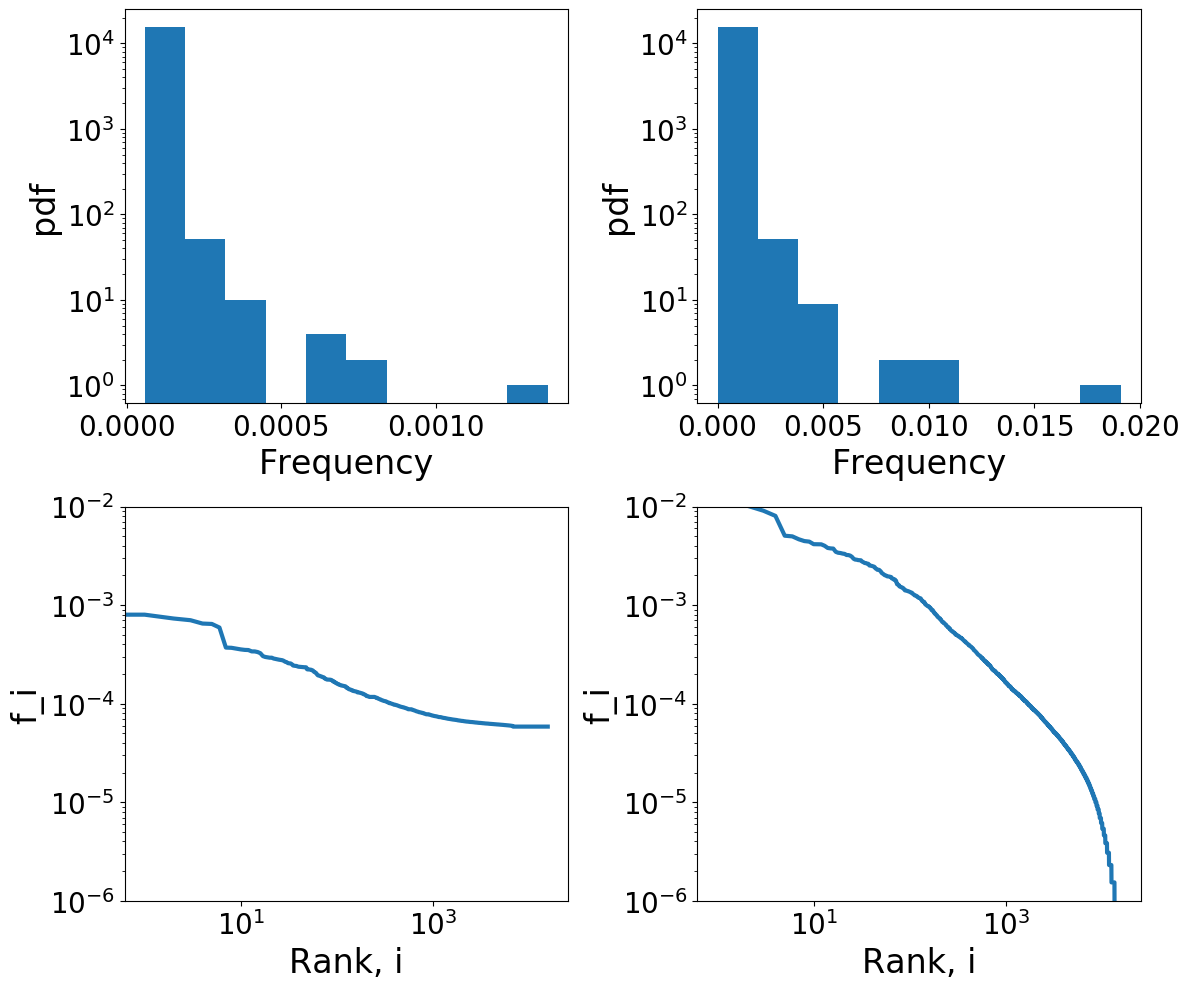

In [63]:
fig, ax = subplots(2,2, figsize=(12,10))
f = data["data"]["means_nonzero"].sort_values(ascending=false)

ax[1].hist(f/f.sum(),  bins=10)
ax[1].set_yscale("log")
ax[1].set_xlabel("Frequency", fontsize=24)
ax[1].set_ylabel("pdf", fontsize=24)

ax[2].plot(f/f.sum())
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_ylim(1e-6,1e-2)
ax[2].set_xlabel("Rank, i", fontsize=24)
ax[2].set_ylabel("f_i", fontsize=24)


f = data["data"]["means"].sort_values(ascending=false)

ax[3].hist(f/f.sum(), bins=10)
ax[3].set_yscale("log")
ax[3].set_xlabel("Frequency", fontsize=24)
ax[3].set_ylabel("pdf", fontsize=24)

ax[4].plot(f/f.sum())
ax[4].set_xscale("log")
ax[4].set_yscale("log")
ax[4].set_ylim(1e-6,1e-2)
ax[4].set_xlabel("Rank, i", fontsize=24)
ax[4].set_ylabel("f_i", fontsize=24)
fig.savefig("f_distribution.pdf")
show()

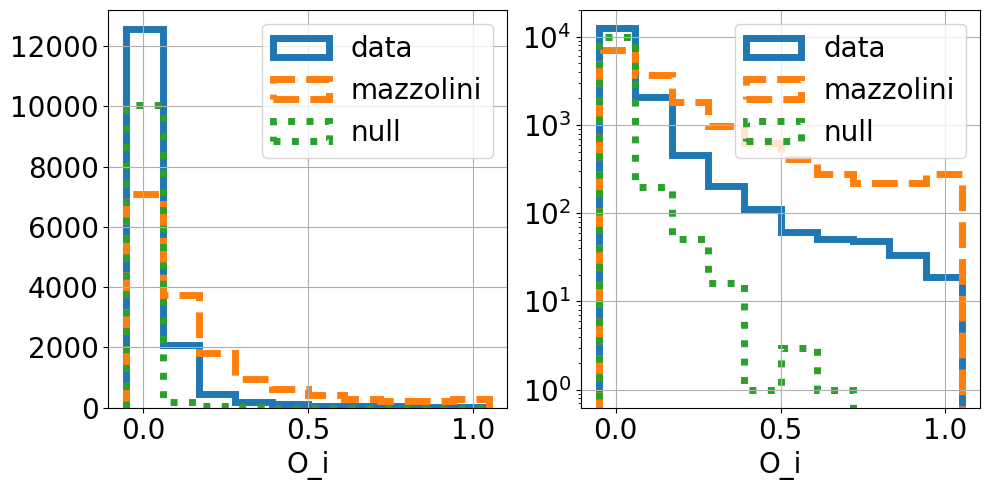

In [64]:
bins=10
rang = (0-0.5/bins, 1+0.5/bins)
fig, ax = subplots(1,2, figsize=(10,5))

data["data"]["O"].hist(histtype="step", lw=5, ax=ax[1], range=rang, bins=bins, label="data")
data["mazzolini"]["O"].hist(histtype="step", lw=5, ax=ax[1], range=rang, bins=bins, ls="--", label="mazzolini")
data["null_1"]["O"].hist(histtype="step", lw=5, ax=ax[1], range=rang, bins=bins, ls=":", label="null")

ax[1].legend(fontsize=20)
ax[1].set_xlabel("O_i")

data["data"]["O"].hist(histtype="step", lw=5, ax=ax[2], range=rang, bins=bins, label="data")
data["mazzolini"]["O"].hist(histtype="step", lw=5, ax=ax[2], range=rang, bins=bins, ls="--", label="mazzolini")
data["null_1"]["O"].hist(histtype="step", lw=5, ax=ax[2], range=rang, bins=bins, ls=":", label="null")

ax[2].set_yscale("log")
ax[2].legend(fontsize=20)
ax[2].set_xlabel("O_i")

fig.savefig("null_1_U.pdf")

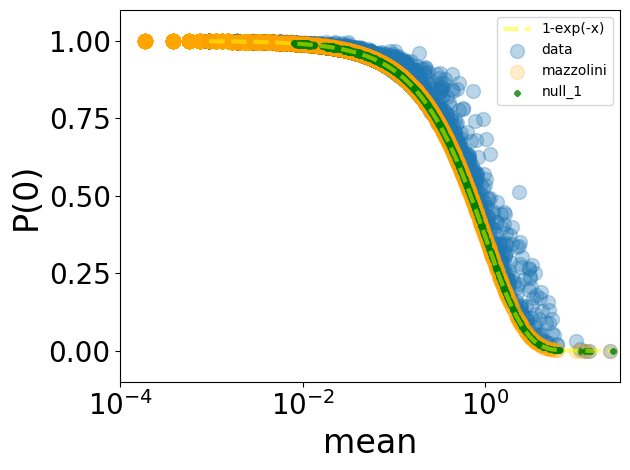

In [65]:
fig, ax = PyPlot.subplots()

function fx(X)
    ret = Vector{Float64}()
    for x in X.sort_values().values
        append!(ret, exp(-x))
    end
   return ret
end

ax.scatter(data["data"]["means"], 1-data["data"]["O"], alpha=0.3, label="data")
ax.plot(data["data"]["means"].sort_values(), fx(data["data"]["means"]), c="yellow", ls="--", alpha=0.5, label="1-exp(-x)")
ax.scatter(data["mazzolini"]["means"].sort_values(), fx(data["mazzolini"]["means"]), c="orange", alpha=0.2, label="mazzolini")
ax.scatter(data["null_1"]["means"].sort_values(), fx(data["null_1"]["means"]), marker="x", s=10, c="green", alpha=0.8, label="null_1")


ax.legend()
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlim(1e-4,30)
ax.set_ylim(-0.1,1.1)

ax.set_xlabel("mean", fontsize=24)
ax.set_ylabel("P(0)", fontsize=24)

fig.savefig("null_1_P_mean.pdf")
show()

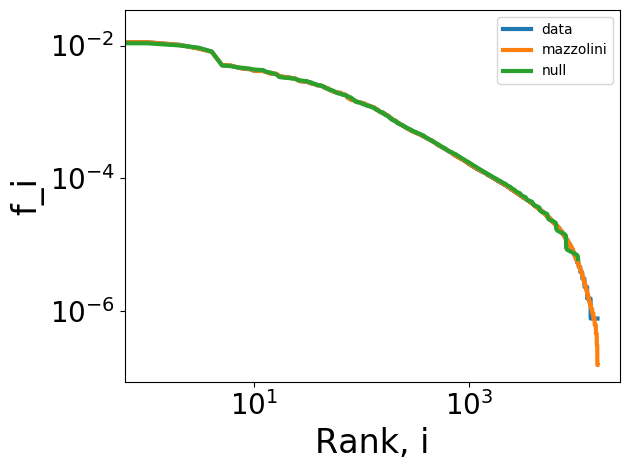

In [66]:
fig, ax = PyPlot.subplots()
ax.plot(data["data"]["freq"].sort_values(ascending=false).values, label="data")
ax.plot(data["mazzolini"]["freq"].sort_values(ascending=false).values, label="mazzolini")
ax.plot(data["null_1"]["freq"].sort_values(ascending=false).values, label="null")

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Rank, i", fontsize=24)
ax.set_ylabel("f_i", fontsize=24)
show()

fig.savefig("null_1_zipf.pdf")

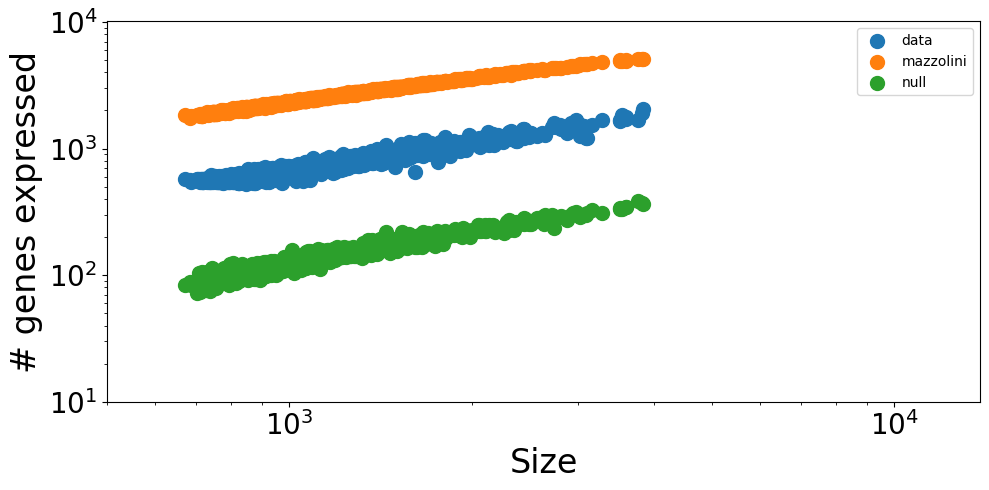

In [67]:
fig, ax = PyPlot.subplots(figsize=(10,5))
ax.scatter(data["data"]["M"].values, data["data"]["diffWords"].values, label="data")
ax.scatter(data["mazzolini"]["M"].values, data["mazzolini"]["diffWords"].values, label="mazzolini")
ax.scatter(data["null_1"]["M"].values, data["null_1"]["diffWords"].values, label="null")


ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(500,data["data"]["M"].max()+1e4)
ax.set_ylim(10,data["mazzolini"]["diffWords"].max()+5e3)

ax.set_xlabel("Size", fontsize=24)

ax.set_ylabel("# genes expressed", fontsize=24)
show()

fig.savefig("null_1_heaps.pdf")